# Time series forecasting with DeepAR - Wikimedia pageview data

This notebook works as an improved example: it trains a deepAR model using 2Years/ over 800 wiki-projects pageview data, and tests the model with both wiki and synthetic data.

In [1]:
import time
import numpy as np
np.random.seed(1)
import pandas as pd
import json
import matplotlib.pyplot as plt
#from preprocessor import save_json

In [2]:
!conda install -y s3fs

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.5.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [3]:
import boto3
import s3fs
import sagemaker
from sagemaker import get_execution_role

In [4]:
bucket = 'sagemaker-deepar20190120'
prefix = 'sagemaker/wiki-test-deepar'

sagemaker_session = sagemaker.Session()
role = get_execution_role()

s3_data_path = "{}/{}/data".format(bucket, prefix)
s3_output_path = "{}/{}/output".format(bucket, prefix)

In [5]:
from sagemaker.amazon.amazon_estimator import get_image_uri
image_name = get_image_uri(boto3.Session().region_name, 'forecasting-deepar')

### Predict setting

We predict the next 48 points of time series.
The time series that we use have hourly granularity.

In [6]:
freq = 'H'
prediction_length = 48

`context_length`: how many previous points to look at. A typical value to start with is around the same size as the `prediction_length`.

In [7]:
context_length = 72

Useful functions convert `pandas.Series` objects into the appropriate JSON strings that DeepAR can consume. We will use these to write the data to S3. (didn't call during this example)

In [8]:
def series_to_obj(ts, cat=None):
    obj = {"start": str(ts.index[0]), "target": list(ts)}
    if cat is not None:
        obj["cat"] = cat
    return obj

def series_to_jsonline(ts, cat=None):
    return json.dumps(series_to_obj(ts, cat))

### Get wikimedia pageview data from its restAPI
For simplicity, I aggregate all page views here. The output json file contains only one line with pageview numbers from `start` to `end`. Output files are saved in a S3 bucket.

In [9]:
import datetime
import requests
import json
import time

all_data = []
project_list = []
delta = datetime.timedelta(days=199)
hour = datetime.timedelta(hours=1)
zero = datetime.timedelta(hours=0)


def save_json(start, end, out_path, input_path):
    s3filesystem = s3fs.S3FileSystem()
    start_date = datetime.datetime.strptime(start, '%Y%m%d')
    end_date = datetime.datetime.strptime(end, '%Y%m%d')
    if (end_date - start_date).days < 0:
        raise Exception('start date should NOT after end date')

    expected_size = ((end_date - start_date).days + 1) * 24

    # provide wiki-project list here!
    with open(input_path) as f:
        projects = f.read().splitlines()

    for item in projects:
        data = get_single_views(item, start_date, end_date)
        if len(data['target']) == expected_size:
            all_data.append(data)

    # convert all items to JSON and write to a file
    print('saving data')
    print(project_list)
    with open('project_list.txt', 'w') as f:
        for item in project_list:
            f.write("%s\n" % item)
    with s3filesystem.open(out_path, 'w') as outfile:
        outfile.write('\n'.join(json.dumps(i) for i in all_data) + '\n')


def get_single_views(item, start_date, end_date):
    base_url = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/' \
               + item \
               + '/all-access/user/hourly/'
    # dict is used to save JSON of each domain
    data = dict()
    data['start'] = start_date.strftime('%Y-%m-%d') + ' 00:00:00'
    data['target'] = []

    while start_date <= end_date:
        if start_date + delta <= end_date:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + (start_date + delta).strftime('%Y%m%d') + '23'
            end_check = start_date + delta + 23 * hour
        else:
            final_url = base_url + start_date.strftime('%Y%m%d') + '00/' \
                        + end_date.strftime('%Y%m%d') + '23'
            end_check = end_date + 23 * hour
        # make a API request here!!!
        response = requests.get(final_url)
        time.sleep(0.05)
        try:
            response.raise_for_status()
        except requests.exceptions.HTTPError as e:
            print("<-----Error---->: " + final_url + str(e))
            break
        print('<-----OK----->' + final_url)  # debug
        output = response.json()
        print('processed data points: ' + str(len(output['items'])))  # debug
        temp = start_date - hour
        for i in output['items']:
            curr = datetime.datetime.strptime(i['timestamp'], '%Y%m%d%H')
            while curr - temp > hour:
                data['target'].append(0)
                temp += hour
            data['target'].append(i['views'])
            temp = curr

        while (end_check - temp) > zero:
            data['target'].append(0)
            temp += hour

        start_date += datetime.timedelta(days=200)

    return data

In [10]:
train_start = '20160101'
train_end = '20180101'
save_json(train_start,train_end,s3_data_path + "/train/train.json", 'wp_full.txt')
test_start = '20180101'
test_end = '20190101'
save_json(test_start,test_end,s3_data_path + "/test/test.json", 'wp_full.txt')

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4770
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4764
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4747
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 3658
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/aa.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 2656
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 396
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 248
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 862
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 644
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 499
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ak.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 355
<-----

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4767
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4758
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4766
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3160
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4491
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ang.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points:

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/arz.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/arz.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/as.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/as.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/as.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/as.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4596
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4657
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4669
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ay.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3126
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/az.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/az.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be-tarask.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be-tarask.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be-tarask.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/be-tarask.wikipedia.org/all-access/user/hourly/2017082300/2018010123
proc

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4785
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4785
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4792
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bg.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3164
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bh.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bh.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3167
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4796
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4794
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4796
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bn.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3139
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4784
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4789
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4794
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3166
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikinews.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4586
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cbk-zam.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cbk-zam.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cbk-zam.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cdo.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cdo.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cdo.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4119
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 3671
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 3211
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2367
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cs.wikiversity.org/all-access/user/hourly/2016010100/2016071823
processed data points: 480

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4799
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/de.wikivoyage.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/diq.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/diq.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/diq.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/diq.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/donate.wikipedia.org/all-access/user/hourly/2016010100/2016071823404 Client Error: No

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4580
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/eo.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4620
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikiversity.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikiversity.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikivoyage.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikivoyage.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikivoyage.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikivoyage.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fa.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiversity.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4753
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiversity.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4754
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiversity.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4766
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiversity.org/all-access/user/hourly/2017082300/2018010123
processed data points:

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikiversity.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fr.wikiversity.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ga.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 3126
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ga.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2365
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gag.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gag.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gag.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gag.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gn.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 105
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gn.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4737
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gn.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4746
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gn.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4768
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gn.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3158
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gom.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4026
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4246
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4252
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2951
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hak.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4795
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4790
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hi.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ht.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2637
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<--

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4052
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4028
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ia.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4344
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ii.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4580
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ii.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/it.wikinews.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kab.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kab.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kab.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kab.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kbd.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kbd.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 480

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4671
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3115
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4798
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ko.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ko.wikiversity.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4796
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ko.wikiversity.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4797
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ko.wikiversity.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ko.wikiversity.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3167
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/koi.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points:

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4703
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4708
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4714
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4739
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4724
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4743
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/la.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3109
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4797
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4432
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4488


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4743
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4768
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3155
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lt.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mdf.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mdf.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mdf.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mg.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mg.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mg.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3162
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4718
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4675
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4673
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3127
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mk.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4741

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4605
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mr.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4534
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mwl.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mwl.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mwl.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/my.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/my.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/my.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nah.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3149
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nap.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nap.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nap.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nap.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nds.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 48

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikinews.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikinews.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3155
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4798
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/no.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3167
<-----

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/om.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4306
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/om.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4227
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/om.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3033
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/or.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pdc.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pdc.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pdc.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pfl.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pfl.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pfl.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 480

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pms.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pms.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pms.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnb.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnb.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pnb.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 480

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikiversity.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikiversity.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikiversity.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikiversity.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikivoyage.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikivoyage.org/all-access/user/hourly/2016071900/2017020323
processed data points:

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4798
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4795
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4797
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3167
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikinews.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikinews.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikinews.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikinews.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ru.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sa.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sah.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 45

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4151
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sg.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4156
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4797
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3167
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4796
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4795
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4799
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sn.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 2120
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sn.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 1962
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sn.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 2237
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sn.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2484
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/so.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/so.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sr.wikiquote.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sr.wikiquote.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sr.wikisource.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sr.wikisource.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sr.wikisource.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sr.wikisource.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sv.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<--

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4793
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3160
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wiktionary.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wiktionary.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tet.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tet.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tg.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tg.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tg.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tg.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 3252
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 3041
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 1966
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 1652
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4434
<--

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tr.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tum.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tum.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikinews.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4781
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikinews.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikinews.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4795
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikinews.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3164
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikiquote.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uk.wikiquote.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ve.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 465

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 3652
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 3100
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 3244
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 2244
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wiktionary.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4750
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vo.wiktionary.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4776
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.mediawiki.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.mediawiki.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikidata.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikidata.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikidata.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikidata.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikipedia.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikipedia.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 2672
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/za.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 1523
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-yue.wikipedia.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-yue.wikipedia.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3168
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh.wikibooks.org/all-access/user/hourly/2016010100/2016071823
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh.wikibooks.org/all-access/user/hourly/2016071900/2017020323
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh.wikibooks.org/all-access/user/hourly/2017020400/2017082223
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh.wikibooks.org/all-access/user/hourly/2017082300/2018010123
processed data points: 3

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ace.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ady.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ady.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/af.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/af.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/af.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4483
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ar.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ar.wikinews.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ar.wikinews.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ar.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ar.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ar.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/az.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/az.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/az.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/azb.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/azb.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ba.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bi.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bi.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 1686
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bi.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 2084
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bi.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 579
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bi.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 2143
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bjn.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4787
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bs.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3983
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bug.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bug.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/bxr.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3983
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4374
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/co.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3839
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/commons.wikipedia.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/commons.wikipedia.org/all-access/user/hourly/2018010100/2018071923
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/cr.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://w

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/da.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikiversity.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikiversity.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/el.wikivoyage.org/all-access/user/hourly/2018010100/2018071923
processed data points: 48

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikiversity.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikivoyage.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/es.wikivoyage.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/et.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/et.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/et.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4750


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiversity.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4756
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fi.wikiversity.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3972
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fiu-vro.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fiu-vro.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/fj.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data po

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ga.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3273
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gag.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gag.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gan.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gan.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/gd.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4512
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ha.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3924
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hak.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hak.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ht.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3583
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/hu.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ig.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ii.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4602
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ii.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3873
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ik.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 2640
<--

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikinews.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikinews.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ja.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/kl.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3924
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4760
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3964
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/km.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ksh.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 3900
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3675
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ku.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lez.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lg.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/lg.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/li.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4064
<--

<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.wikimediafoundation.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.wikimediafoundation.org/all-access/user/hourly/2018010100/2018071923
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.wikisource.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.wikisource.org/all-access/user/hourly/2018010100/2018071923
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.mediawiki.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/m.mediawiki.org/all-access/user/hourly/2018010100/2018071923
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregat

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ml.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ml.wikiversity.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ml.wikiversity.org/all-access/user/hourly/2018010100/2018071923
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mn.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mn.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mn.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 2443
<-----OK----->https://wikimed

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/mzn.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/na.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/na.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/na.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 2207
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/na.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 2628
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/na.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4647
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikivoyage.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nl.wikivoyage.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nn.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nn.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/nn.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4790


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/os.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/os.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pa.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pa.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pa.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4082
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pa.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3691
<---

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ps.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ps.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 2062
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ps.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 2224
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ps.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4709
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ps.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3970
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/pt.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikivoyage.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4773
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ro.wikivoyage.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3979
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/roa-rup.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sc.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3348
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/scn.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/scn.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/scn.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/scn.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sco.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sk.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3954
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sl.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sl.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sl.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4762
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sl.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3966
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/sl.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4798
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ss.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ss.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4616
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ss.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3910
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/st.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/st.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/st.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4727
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikinews.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4790
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ta.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/te.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<--

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2018010100/2018071923
processed data points: 2272
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikibooks.org/all-access/user/hourly/2018072000/2019010123
processed data points: 2789
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4627
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3896
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tk.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 3293
<-

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tt.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3474
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tum.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tum.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/tw.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 3740
<

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/uz.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3905
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ve.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/ve.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/vec.wiktionary.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4780


<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/wo.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3447
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/wuu.wikipedia.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/wuu.wikipedia.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3984
<-----Error---->: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikipedia.org/all-access/user/hourly/2018010100/2018071923404 Client Error: Not Found for url: https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.wikipedia.org/all-access/user/hourly/2018010100/2018071923
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/www.mediawiki.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4800
<-----OK----->https://wikimed

<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-min-nan.wiktionary.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3983
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-min-nan.wikiquote.org/all-access/user/hourly/2018010100/2018071923
processed data points: 3795
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-min-nan.wikiquote.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3673
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-min-nan.wikisource.org/all-access/user/hourly/2018010100/2018071923
processed data points: 4443
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-min-nan.wikisource.org/all-access/user/hourly/2018072000/2019010123
processed data points: 3864
<-----OK----->https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/zh-yue.wikipedia.org/all-access/user/hourly/2018010

### Train a model

In [11]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.c4.xlarge',
    base_job_name='DEMO-deepar',
    output_path="s3://" + s3_output_path
)

In [12]:
hyperparameters = {
    "time_freq": freq,
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
    "num_cells": "40",
    "num_layers": "3",
    "likelihood": "gaussian",
    "epochs": "20",
    "mini_batch_size": "32",
    "learning_rate": "0.001",
    "dropout_rate": "0.05",
    "early_stopping_patience": "10"
}

In [13]:
estimator.set_hyperparameters(**hyperparameters)

In [14]:
data_channels = {
    "train": "s3://{}/train/".format(s3_data_path),
    "test": "s3://{}/test/".format(s3_data_path)
}

estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: DEMO-deepar-2019-01-24-05-33-32-468


2019-01-24 05:33:32 Starting - Starting the training job...
2019-01-24 05:33:33 Starting - Launching requested ML instances...
2019-01-24 05:34:31 Starting - Preparing the instances for training......
2019-01-24 05:35:31 Downloading - Downloading input data
2019-01-24 05:35:31 Training - Downloading the training image.....
Arguments: train
[01/24/2019 05:36:13 INFO 140424965760832] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[01/24/2019 05:36:13 INFO 14042

[01/24/2019 05:36:42 INFO 140424965760832] processed a total of 791 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6460.198879241943, "sum": 6460.198879241943, "min": 6460.198879241943}}, "EndTime": 1548308202.686479, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548308196.226223}

[01/24/2019 05:36:42 INFO 140424965760832] #throughput_metric: host=algo-1, train throughput=122.439909019 records/second
[01/24/2019 05:36:42 INFO 140424965760832] #progress_metric: host=algo-1, completed 15 % of epochs
[01/24/2019 05:36:42 INFO 140424965760832] best epoch loss so far
[01/24/2019 05:36:42 INFO 140424965760832] Saved checkpoint to "/opt/ml/model/state_bbe797a7-dc42-4e45-9b08-8f623e95ceeb-0000.params"
#metrics {"Metrics": {"state.serialize.time": {"count": 1, "max": 41.36204719543457, "sum": 41.36204719543457, "min": 41.36204719543457}}, "EndTime": 1548308202.728383, "Dimensions": {"Host": "algo-1", "Operation": "trainin

[01/24/2019 05:37:18 INFO 140424965760832] Epoch[8] Batch[10] avg_epoch_loss=7.840730
[01/24/2019 05:37:18 INFO 140424965760832] Epoch[8] Batch [10]#011Speed: 96.83 samples/sec#011loss=6.721415
[01/24/2019 05:37:19 INFO 140424965760832] Epoch[8] Batch[15] avg_epoch_loss=7.518970
[01/24/2019 05:37:19 INFO 140424965760832] Epoch[8] Batch [15]#011Speed: 186.68 samples/sec#011loss=6.811098
[01/24/2019 05:37:21 INFO 140424965760832] Epoch[8] Batch[20] avg_epoch_loss=7.348837
[01/24/2019 05:37:21 INFO 140424965760832] Epoch[8] Batch [20]#011Speed: 119.97 samples/sec#011loss=6.804410
[01/24/2019 05:37:21 INFO 140424965760832] Epoch[8] Batch[25] avg_epoch_loss=7.112369
[01/24/2019 05:37:21 INFO 140424965760832] Epoch[8] Batch [25]#011Speed: 173.61 samples/sec#011loss=6.119203
[01/24/2019 05:37:21 INFO 140424965760832] processed a total of 804 examples
#metrics {"Metrics": {"update.time": {"count": 1, "max": 6628.2172203063965, "sum": 6628.2172203063965, "min": 6628.2172203063965}}, "EndTime": 

[01/24/2019 05:37:49 INFO 140424965760832] Epoch[13] Batch[0] avg_epoch_loss=6.298347
[01/24/2019 05:37:50 INFO 140424965760832] Epoch[13] Batch[5] avg_epoch_loss=7.064134
[01/24/2019 05:37:50 INFO 140424965760832] Epoch[13] Batch [5]#011Speed: 190.65 samples/sec#011loss=7.064134
[01/24/2019 05:37:51 INFO 140424965760832] Epoch[13] Batch[10] avg_epoch_loss=6.981519
[01/24/2019 05:37:51 INFO 140424965760832] Epoch[13] Batch [10]#011Speed: 100.94 samples/sec#011loss=6.882381
[01/24/2019 05:37:52 INFO 140424965760832] Epoch[13] Batch[15] avg_epoch_loss=6.965818
[01/24/2019 05:37:52 INFO 140424965760832] Epoch[13] Batch [15]#011Speed: 186.29 samples/sec#011loss=6.931276
[01/24/2019 05:37:53 INFO 140424965760832] Epoch[13] Batch[20] avg_epoch_loss=6.943853
[01/24/2019 05:37:53 INFO 140424965760832] Epoch[13] Batch [20]#011Speed: 115.86 samples/sec#011loss=6.873567
[01/24/2019 05:37:54 INFO 140424965760832] Epoch[13] Batch[25] avg_epoch_loss=6.877260
[01/24/2019 05:37:54 INFO 140424965760832

[01/24/2019 05:38:48 INFO 140424965760832] Number of test batches scored: 10
[01/24/2019 05:39:11 INFO 140424965760832] Number of test batches scored: 20
[01/24/2019 05:39:34 INFO 140424965760832] Number of test batches scored: 30
[01/24/2019 05:39:56 INFO 140424965760832] Number of test batches scored: 40
[01/24/2019 05:40:18 INFO 140424965760832] Number of test batches scored: 50
#metrics {"Metrics": {"model.score.time": {"count": 1, "max": 114372.57194519043, "sum": 114372.57194519043, "min": 114372.57194519043}}, "EndTime": 1548308420.686788, "Dimensions": {"Host": "algo-1", "Operation": "training", "Algorithm": "AWS/DeepAR"}, "StartTime": 1548308306.314311}

[01/24/2019 05:40:20 INFO 140424965760832] #test_score (algo-1, RMSE): 240757.120435
[01/24/2019 05:40:20 INFO 140424965760832] #test_score (algo-1, mean_wQuantileLoss): 0.830187
[01/24/2019 05:40:20 INFO 140424965760832] #test_score (algo-1, wQuantileLoss[0.1]): 0.649065
[01/24/2019 05:40:20 INFO 140424965760832] #test_score 

### Create endpoint and predictor

In [15]:
job_name = estimator.latest_training_job.name

endpoint_name = sagemaker_session.endpoint_from_job(
    job_name=job_name,
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    deployment_image=image_name,
    role=role
)

INFO:sagemaker:Creating model with name: DEMO-deepar-2019-01-24-05-33-32-468
INFO:sagemaker:Creating endpoint-config with name DEMO-deepar-2019-01-24-05-33-32-468
INFO:sagemaker:Creating endpoint with name DEMO-deepar-2019-01-24-05-33-32-468


---------------------------------------------------------------------------!

In [16]:
class DeepARPredictor(sagemaker.predictor.RealTimePredictor):

    def set_prediction_parameters(self, freq, prediction_length):
        """Set the time frequency and prediction length parameters. This method **must** be called
        before being able to use `predict`.
        
        Parameters:
        freq -- string indicating the time frequency
        prediction_length -- integer, number of predicted time points
        
        Return value: none.
        """
        self.freq = freq
        self.prediction_length = prediction_length
        
    def predict(self, ts, cat=None, encoding="utf-8", num_samples=100, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        Parameters:
        ts -- list of `pandas.Series` objects, the time series to predict
        cat -- list of integers (default: None)
        encoding -- string, encoding to use for the request (default: "utf-8")
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_times = [x.index[-1]+1 for x in ts]
        req = self.__encode_request(ts, cat, encoding, num_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, prediction_times, encoding)
    
    def __encode_request(self, ts, cat, encoding, num_samples, quantiles):
        instances = [series_to_obj(ts[k], cat[k] if cat else None) for k in range(len(ts))]
        configuration = {"num_samples": num_samples, "output_types": ["quantiles"], "quantiles": quantiles}
        http_request_data = {"instances": instances, "configuration": configuration}
        return json.dumps(http_request_data).encode(encoding)
    
    def __decode_response(self, response, prediction_times, encoding):
        response_data = json.loads(response.decode(encoding))
        list_of_df = []
        for k in range(len(prediction_times)):
            prediction_index = pd.DatetimeIndex(start=prediction_times[k], freq=self.freq, periods=self.prediction_length)
            list_of_df.append(pd.DataFrame(data=response_data['predictions'][k]['quantiles'], index=prediction_index))
        return list_of_df

In [17]:
predictor = DeepARPredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    content_type="application/json"
)
predictor.set_prediction_parameters(freq, prediction_length)

## Make predictions, plot and evaluate the results

### Make prediction for `wiki` data

In [20]:
data_location = "s3://{}/wiki/test_wiki.json".format(s3_data_path)
df_ts = pd.read_json(data_location, lines = True)
df_ts.head()

,start,target
0,2018-01-01 00:00:00,"[12246074, 12245172, 12232665, 12249950, 12426..."
1,2018-01-01 00:00:00,"[1623656, 1013234, 662945, 483863, 347801, 313..."
2,2018-01-01 00:00:00,"[1143073, 1320756, 1469240, 1541884, 1606354, ..."
3,2018-01-01 00:00:00,"[336642, 430426, 533096, 624273, 659660, 70732..."
4,2018-01-01 00:00:00,"[804791, 627051, 498856, 460985, 492686, 56540..."


In [21]:
num_pt = len(df_ts.iloc[1,1])
num_ts = len(df_ts)-1

time_series_wiki = [] 
for k in range(num_ts):
    t0 = df_ts.iloc[k,0]
    data = df_ts.iloc[k,1]
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
    time_series_wiki.append(pd.Series(data=data, index=index))

In [22]:
time_series_wiki_predict = []
for ts in time_series_wiki:
    time_series_wiki_predict.append(ts[:-prediction_length])

In [23]:
list_of_wiki_pred = predictor.predict(time_series_wiki_predict[:5])
actual_wiki = time_series_wiki[:5]

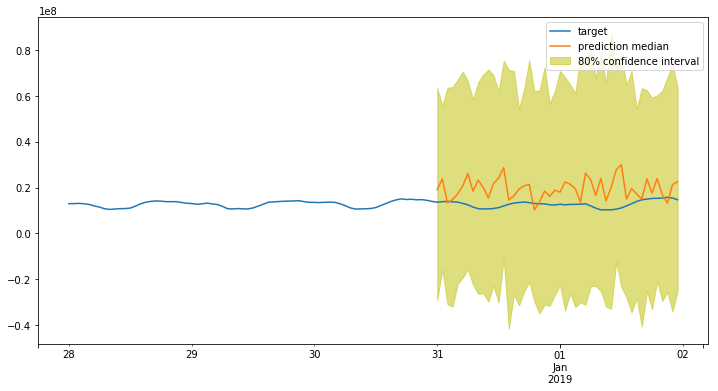

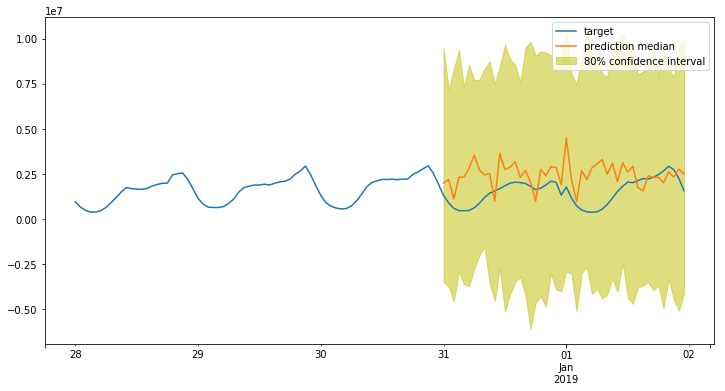

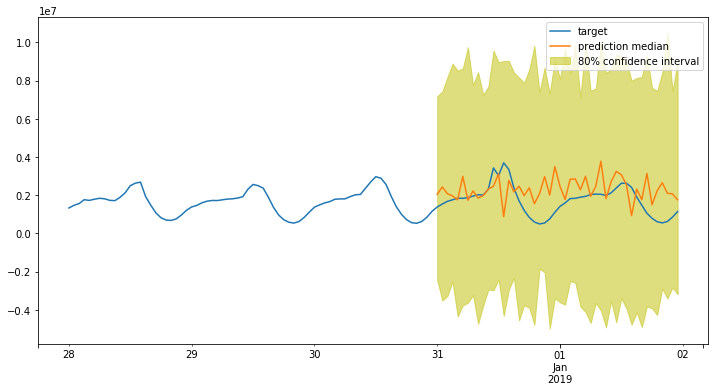

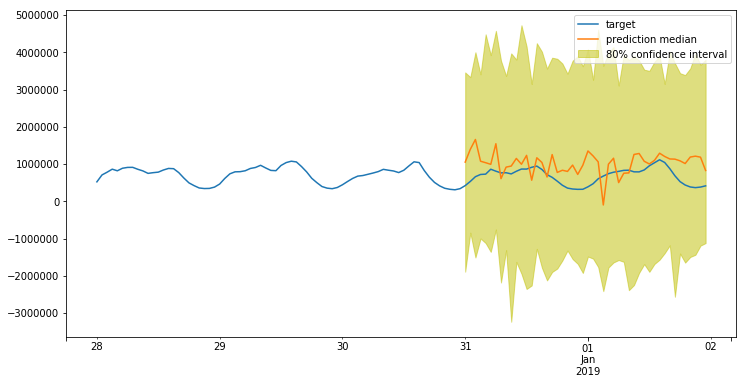

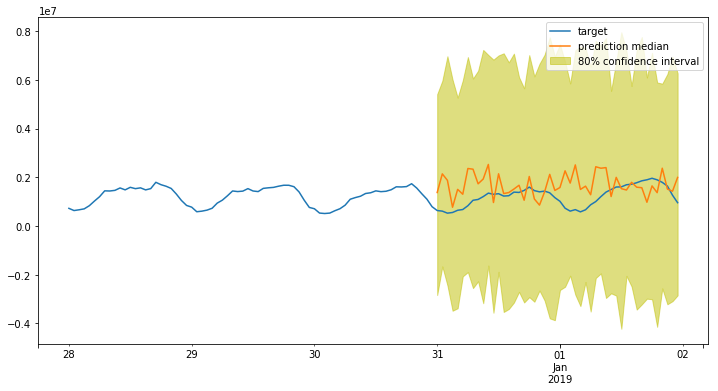

In [24]:
for k in range(len(list_of_wiki_pred)):
    plt.figure(figsize=(12,6))
    actual_wiki[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_wiki_pred[k]['0.1']
    p90 = list_of_wiki_pred[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_wiki_pred[k]['0.5'].plot(label='prediction median')
    plt.legend()
    plt.show()

### Make prediction for `synthetic` data: sin() with noise.

Data contain 200 noisy time series, each consisting of 400 data points and with seasonality of 24 hours. 
All time series start at the same time point `t0`.

In [25]:
t0 = '2016-01-01 00:00:00'
data_length = 400
num_ts = 200
period = 24

In [37]:
time_series_synthetic = []
for k in range(num_ts):
    level = 10000 * np.random.rand()
    seas_amplitude = (0.1 + 0.3*np.random.rand()) * level
    sig = 0.05 * level # noise parameter (constant in time)
    time_ticks = np.array(range(data_length))
    source = level + seas_amplitude*np.sin(time_ticks*(2*np.pi)/period)
    noise = sig*np.random.randn(data_length)
    data = source + noise
    index = pd.DatetimeIndex(start=t0, freq=freq, periods=data_length)
    time_series_synthetic.append(pd.Series(data=data, index=index))

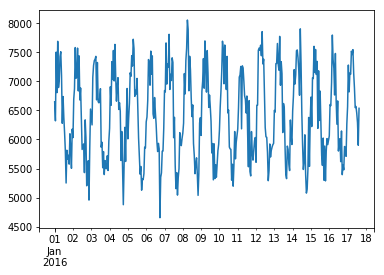

In [38]:
time_series_synthetic[0].plot()
plt.show()

In [39]:
time_series_to_predict = []
for ts in time_series_synthetic:
    time_series_to_predict.append(ts[:-prediction_length])

In [40]:
list_of_df = predictor.predict(time_series_to_predict[:5])
actual_data = time_series_synthetic[:5]

In [41]:
len(list_of_df[0]['0.5'].values)

48

In [42]:
len(actual_data[0][-prediction_length:].values)

48

### moving average as a baseline model

- not able to handle seasonality

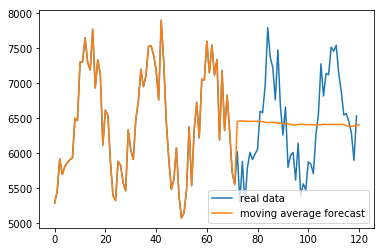

In [43]:
db = actual_data[0][-prediction_length-context_length:].values
forecast = np.zeros(len(db) + 1)
optimal_n = context_length
for i in range(0, optimal_n):
    forecast[i] = db[i]
for i in range(0, len(db) - optimal_n + 1):
        forecast[i+optimal_n] = np.mean(db[i:i+optimal_n])
plt.plot(db,label = 'real data')
plt.plot(forecast, label = 'moving average forecast')
plt.legend()
plt.show()


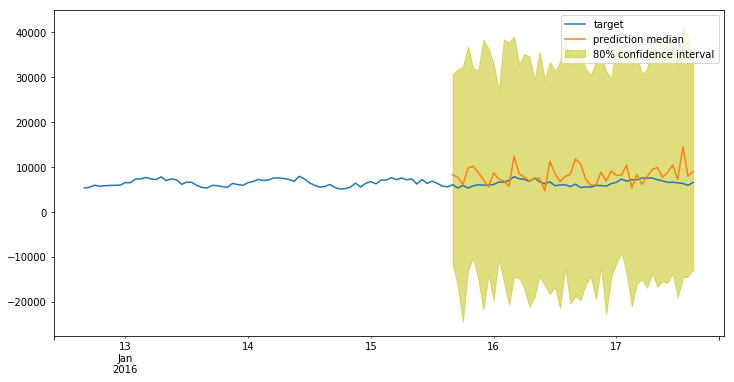

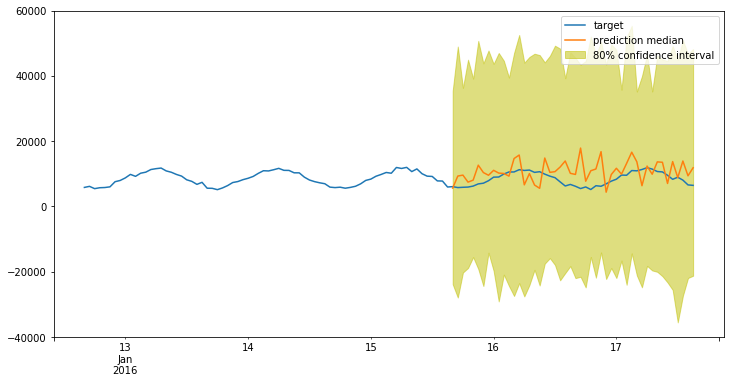

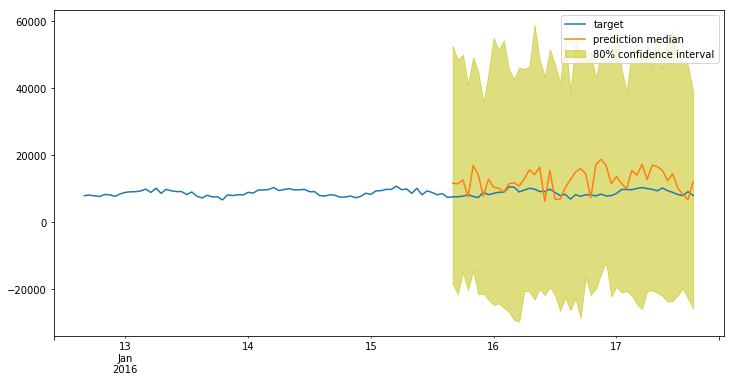

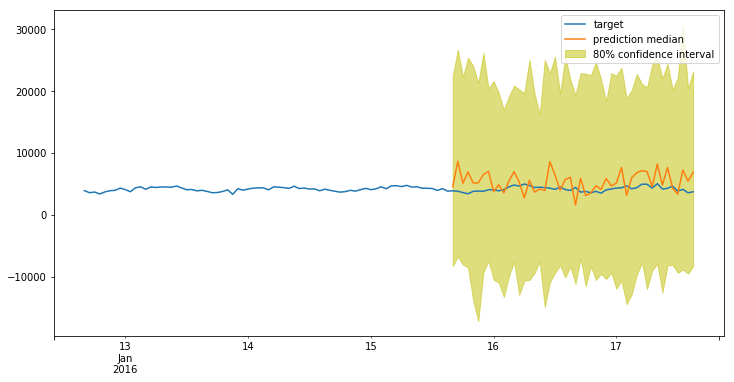

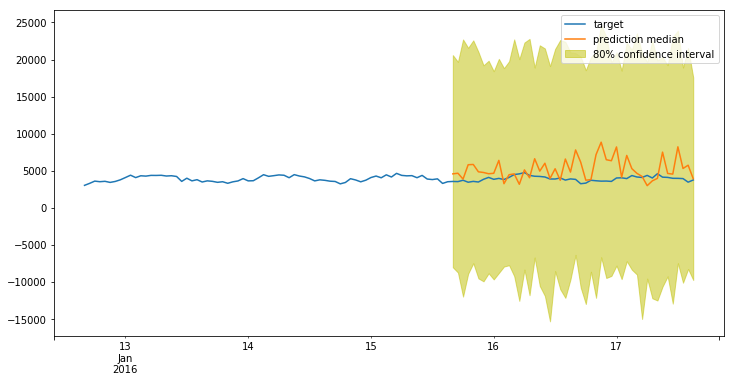

In [44]:
for k in range(len(list_of_df)):
    plt.figure(figsize=(12,6))
    actual_data[k][-prediction_length-context_length:].plot(label='target')
    p10 = list_of_df[k]['0.1']
    p90 = list_of_df[k]['0.9']
    plt.fill_between(p10.index, p10, p90, color='y', alpha=0.5, label='80% confidence interval')
    list_of_df[k]['0.5'].plot(label='prediction median')
    #plt.plot(forecast, label = 'moving average forecast')
    plt.legend()
    plt.show()

### Metrics to evaluate the prediction
- Mean absolute percentage error
- Mean absolute error with log1p
- Symmetric mean absolute percentage error
- Symmetric mean absolute percentage error differentiable
- others?

In [67]:
# Approximated differentiable SMAPE
def differentiable_smape(true, predicted):
    epsilon = 0.1
    true_o = true
    pred_o = predicted
    summ = np.maximum(np.abs(true_o) + np.abs(pred_o) + epsilon, 0.5 + epsilon)
    smape = np.abs(pred_o - true_o) / summ
    return smape

# SMAPE, rounded up to the closest integer
def rounded_smape(true, predicted):
    true_o = np.int(np.round(true))
    pred_o = np.round(predicted).astype(np.int32)
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# SMAPE stardard definition
def smape(true, predicted):
    true_o = true
    pred_o = predicted
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return smape

# MAE standard definition
def mape(true, predicted):
    true_o = true
    pred_o = predicted
    denom = np.abs(true_o)
    mape = np.where(denom==0, 0, np.abs(pred_o - true_o) / denom)
    return mape


# MAE on log1p
def mape1p(true, predicted):
    epsilon = 0.1
    true_o = np.log1p(true + epsilon)
    pred_o = np.log1p(predicted + epsilon)
    error = np.abs(true_o - pred_o)/np.abs(true_o)
    return error

In [68]:
# input pd.series in which index = time stamps, value = time series values
# actual_series and pred_series should have exactly matched timestamps

def plot_metrics(actual_series, pred_series):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    metric_smape = differentiable_smape(actual_series.values, pred_series.values)
    metric_mape = mape(actual_series.values, pred_series.values)
    metric_maelog1p = mape1p(actual_series.values, pred_series.values)
    metric_smape_orig = smape(actual_series.values, pred_series.values)
    plt.figure(figsize=(12,6))
    plt.plot(pred_series.index, metric_smape_orig, label = 'smape standard = {}'.format(metric_smape_orig.mean()))  
    plt.plot(pred_series.index, metric_smape, label = 'smape differentialble = {}'.format(metric_smape.mean()))
    plt.plot(pred_series.index, metric_mape, label = 'mape standard = {}'.format(metric_mape.mean()))
    plt.plot(pred_series.index, metric_maelog1p, label = 'mape with log(1 + eplison +val) = {}'.format(metric_maelog1p.mean()))
    plt.xlabel('Time stamp of prediction')
    plt.ylabel('Prediction metric')
    plt.legend()
    plt.show()

### Plot the metrics for wiki data prediction

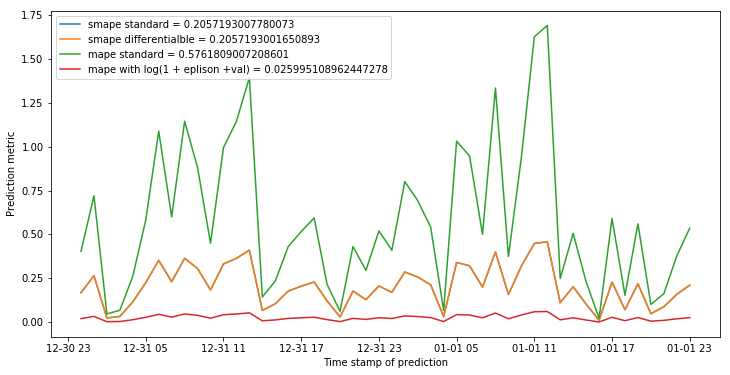

In [70]:
plot_metrics(actual_wiki[0][-prediction_length:], list_of_wiki_pred[0]['0.5'])

### Plot the metrics for synthetic data prediction

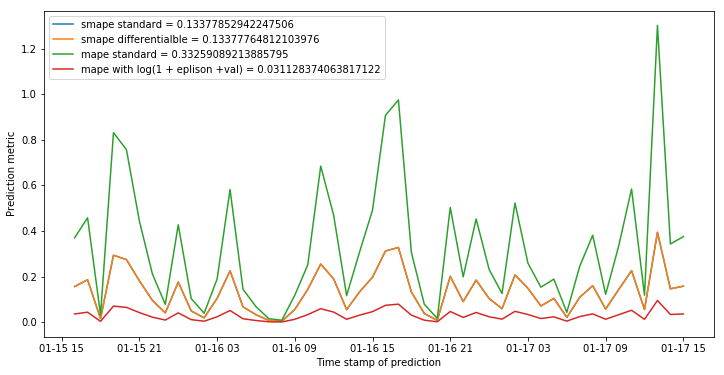

In [69]:
plot_metrics(actual_data[0][-prediction_length:], list_of_df[0]['0.5'])

### Delete endpoint

In [ ]:
sagemaker_session.delete_endpoint(endpoint_name)